# Multi-Model Fusion for Animal Detection and Classification

This notebook implements a multi-model fusion approach that combines YOLO object detection and two different classifiers (YOLO classifier and EfficientNet) for improved animal classification. The approach uses cross-attention to effectively combine features from both classification models.

## Install Dependencies


In [1]:
# Install Dependencies (if needed)
%pip install ultralytics torch torchvision opencv-python-headless

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import Libraries

Import all required Python libraries for our project.

In [2]:
# %pip uninstall -y torch torchvision
%pip install torch torchvision
import os
import logging
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from ultralytics import YOLO
from sklearn.metrics import classification_report
from ultralytics.utils import LOGGER
LOGGER.setLevel(logging.ERROR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"★ Using {device}")



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
★ Using cuda


## Initialize Models and Freeze Weights

We'll use three pre-trained models:
1. YOLO detection model - to detect animals in images
2. YOLO classifier - for feature extraction and classification
3. EfficientNet - for additional feature extraction and classification

We freeze the weights of all three models as we'll use them as feature extractors.

In [3]:
detection_model = YOLO('yolo12l.pt').eval()
for p in detection_model.parameters():
    p.requires_grad_(False)

# Classification Models
yolo_cls = YOLO('yolo11x-cls.pt').eval()
effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).eval()

# Freeze classifiers
for model in [yolo_cls, effnet]:
    for p in model.parameters():
        p.requires_grad_(False)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## Map Model Categories to high-level classes

Create a mapping from the classes output from the classification models to our own high level classes

In [4]:
def get_animal_category_mapping():
    """
    Define mappings from specific species to our 4 high-level categories
    """
    big_cats = ['tiger', 'lion', 'leopard', 'cheetah', 'jaguar', 'puma', 'lynx', 'cougar', 'panther','snow leopard']
    bears = ['bear', 'brown bear', 'polar bear', 'grizzly', 'black bear', 'panda','American_black_bear']
    deers = ['deer', 'elk', 'moose', 'reindeer', 'antelope', 'gazelle', 'impala']
    big_dogs = ['wolf', 'coyote', 'fox', 'hyena', 'jackal', 'dingo', 'wild dog']
    
    yolo_classes = detection_model.names
    
    yolo_mapping = {}
    
    for idx, name in yolo_classes.items():
        name = name.lower()
        if any(cat in name for cat in big_cats):
            yolo_mapping[idx] = 0  # big cat
        elif any(cat in name for cat in bears):
            yolo_mapping[idx] = 1  # bear
        elif any(cat in name for cat in deers):
            yolo_mapping[idx] = 2  # deer
        elif any(cat in name for cat in big_dogs):
            yolo_mapping[idx] = 3  # big dog
    
    return {
        "mapping": yolo_mapping,
        "category_names": ["big cat", "bear", "deer", "big dog"]
    }


## Create Custom Dataset for Animal Detection

We implement a custom PyTorch Dataset that:
1. Loads images from a directory
2. Uses the YOLO detection model to identify animals
3. Crops the regions containing animals
4. Transforms these crops for use with our classifiers
5. Handles train/test splitting and class imbalance

In [ ]:
#Training transform: Apply data augmentation to improve model generalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

#Testing: Only resize and normalize, no augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

class AnimalDataset(Dataset):
    """

    Custom PyTorch dataset for animal classification with detection-based cropping.
    
    root_dir/
        big cats/
        bear/
        deer/
        big dog/
    """
    def __init__(self,
                 root_dir: str,
                 img_size: int = 224,
                 split: str = "train",
                 train_ratio: float = 0.8,
                 transform=None):

        self.root_dir  = root_dir
        self.split     = split
        self.img_size  = img_size
        self.transform = transform or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

        #Scans the directory and also the subdirectory for images 
        self.classes      = sorted([d for d in os.listdir(root_dir)
                                    if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.image_paths, self.labels = [], []
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.image_paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])

        
        idxs = np.random.permutation(len(self.image_paths))
        cut  = int(len(idxs) * train_ratio)
        self.idxs = idxs[:cut] if split == "train" else idxs[cut:]

        # (optional) weights for imbalance
        if split == "train":
            counts   = np.bincount(np.array(self.labels)[self.idxs],
                                   minlength=len(self.classes))
            self.weights = 1. / counts[self.labels][self.idxs]
        print(f"✔ {split}: {len(self.idxs)} samples  | classes = {self.classes}")

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        real_idx = self.idxs[i]
        img_path = self.image_paths[real_idx]
        label    = self.labels[real_idx]

        img      = Image.open(img_path).convert("RGB")
        np_img   = np.array(img)

        # 2. detector – crop OR fallback to full image
        try:
            with torch.no_grad():
                det   = detection_model(np_img)[0]          # YOLO result
                boxes = det.boxes.xyxy.cpu().numpy()
        except Exception:
            boxes = np.array([])

        if boxes.size:                              # at least one box
            x1, y1, x2, y2 = map(int, boxes[0])
            x2 = max(x2, x1 + 1);  y2 = max(y2, y1 + 1)   # safety
            crop = img.crop((x1, y1, x2, y2))
        else:
            crop = img                                 # fallback = full img

        # --------------------------------------------------------------
        # 3. transform → tensor
        # --------------------------------------------------------------
        tensor = self.transform(crop)
        return tensor, label


### Display Random Imgaes from the dataset with their cropped version to check the working of the detector

In [6]:
def show_random_animal_crops(dataset, num_samples=3, max_crops_per_image=5):
    """
    Randomly selects images from a dataset and displays their original and cropped versions
    
    Args:
        dataset: PyTorch dataset to sample from
        num_samples: Number of random samples to display
        max_crops_per_image: Maximum number of crops to display per image
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2
    
    # Sample random indices from the dataset
    indices = np.random.choice(len(dataset.idxs), min(num_samples, len(dataset.idxs)), replace=False)
    
    for idx in indices:
        true_idx = dataset.idxs[idx]
        img_path = dataset.image_paths[true_idx]
        class_name = dataset.classes[dataset.labels[true_idx]]
        
        print(f"\nExample from class: {class_name}")
        print(f"Image path: {img_path}")
        
        # Load and process image
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Detect animals
        results = detection_model(img_rgb)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        
        # Filter and crop animal detections
        animal_crops = []
        
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            crop = img_rgb[y1:y2, x1:x2]
            if crop.size > 0:
                animal_crops.append(crop)            
                if len(animal_crops) >= max_crops_per_image:
                    break
        
        # Display original image and crops
        n_crops = len(animal_crops)
        
        if n_crops == 0:
            plt.figure(figsize=(6, 6))
            plt.imshow(img_rgb)
            plt.title(f"Original Image: {class_name} (No animals detected)")
            plt.axis('off')
            plt.show()
        else:
            fig, axes = plt.subplots(1, n_crops + 1, figsize=(4 * (n_crops + 1), 4))
            
            # Original image
            axes[0].imshow(img_rgb)
            axes[0].set_title(f"Original: {class_name}")
            axes[0].axis('off')
            
            # Cropped animals
            for i, crop in enumerate(animal_crops):
                axes[i+1].imshow(crop)
                axes[i+1].set_title(f"Crop {i+1}")
                axes[i+1].axis('off')
                
                # Draw the crop region on the original image
                rect = plt.Rectangle(
                    (boxes[i][0], boxes[i][1]),
                    boxes[i][2] - boxes[i][0],
                    boxes[i][3] - boxes[i][1],
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                axes[0].add_patch(rect)
            
            plt.tight_layout()
            plt.show()
        
        print(f"Found {len(animal_crops)} animal crop(s)")
        

## 5. Implement Feature Extractors

To leverage the power of both YOLO and EfficientNet, we create feature extractor classes that will extract features from the intermediate layers of these models instead of using just their final classification output.

In [7]:
# Implement Feature Extractors (Remove YOLOFeatureExtractor class)

# For EfficientNet
class EffNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = nn.Sequential(
            model.features,
            model.avgpool
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.features(x)
        return self.flatten(x)

# Initialize feature extractors (Only EfficientNet remains)
effnet_feature_extractor = EffNetFeatureExtractor(effnet).to(device)
dummy = torch.zeros(1, 3, 224, 224).to(device)
with torch.no_grad():
    effnet_dummy_feats = effnet_feature_extractor(dummy)

effnet_dim = effnet_dummy_feats.shape[1]
print(f"Detected feature dims → EffNet: {effnet_dim}")

Detected feature dims → EffNet: 1280


## 6. Build Fusion Model with Cross-Attention

We implement a fusion model that uses cross-attention to combine features from both YOLO classifier and EfficientNet. This allows the model to leverage the strengths of both architectures for better classification performance.

In [8]:
# Build Fusion Model with Cross-Attention (Modify to use only EfficientNet features)

class EfficientNetOnlyClassifier(nn.Module):
    # Renamed class to reflect its new purpose
    def __init__(self, effnet_dim, num_classes):
        super().__init__()
        # Classifier now takes effnet_dim as input
        self.classifier = nn.Sequential(
            nn.Linear(effnet_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, effnet_feats):
        # Pass EfficientNet features through classifier
        return self.classifier(effnet_feats)

## 7. Configure Training Setup

Set up the dataset, data loader, loss function, and optimizer for training the fusion model.

✔ train: 5481 samples  | classes = ['bear', 'big cat', 'big dog', 'deer']
✔ test: 1371 samples  | classes = ['bear', 'big cat', 'big dog', 'deer']

Example from class: deer
Image path: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset\deer\SEQ79933_IMG_0006.JPG


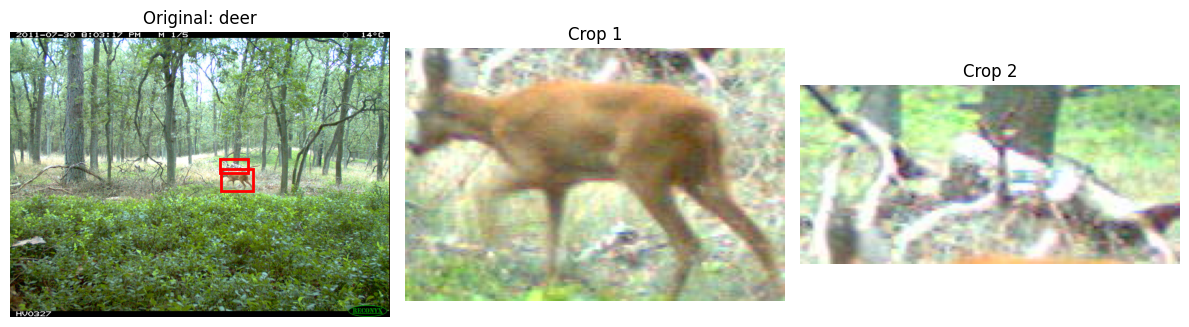

Found 2 animal crop(s)

Example from class: big dog
Image path: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset\big dog\000000002852.jpg


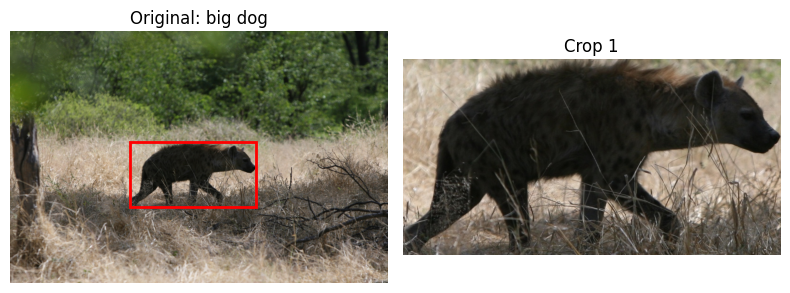

Found 1 animal crop(s)

Example from class: bear
Image path: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset\bear\9184.jpg


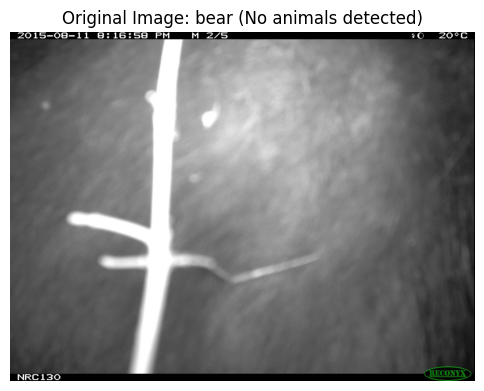

Found 0 animal crop(s)

Example from class: big dog
Image path: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset\big dog\000000002230.jpg


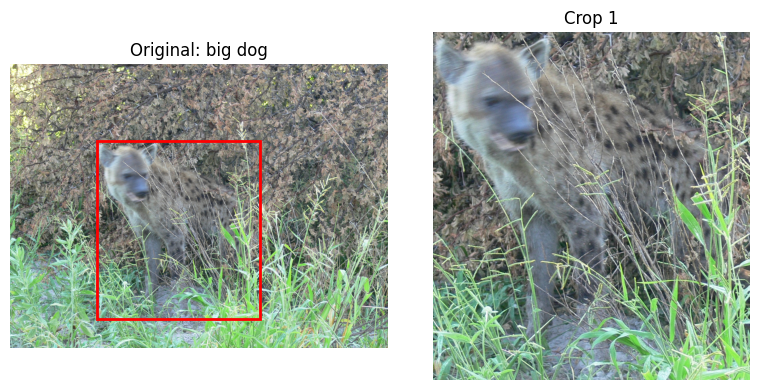

Found 1 animal crop(s)

Example from class: big cat
Image path: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset\big cat\000000000466.jpg


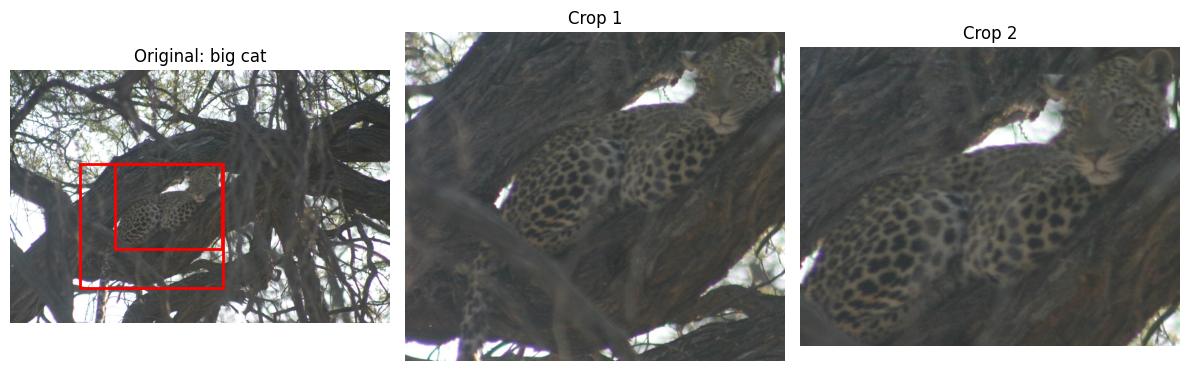

Found 2 animal crop(s)

Example from class: big cat
Image path: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset\big cat\1266.jpg


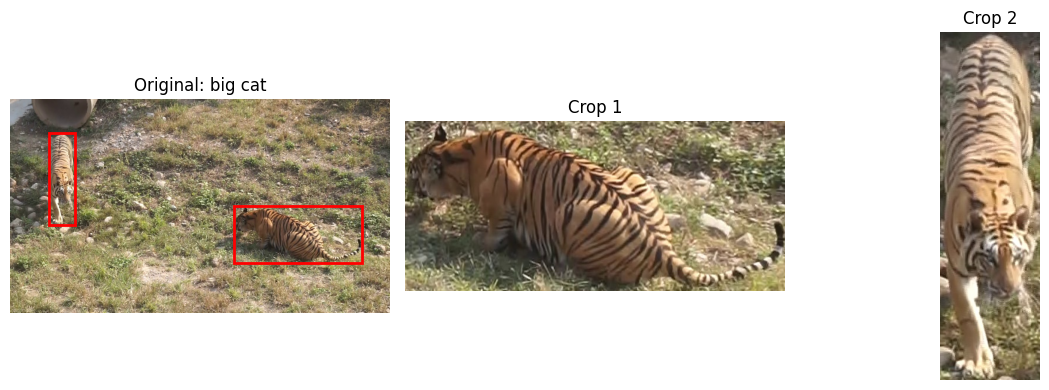

Found 2 animal crop(s)
Detected feature dims → EffNet: 1280
Training dataset contains 5481 images
Test dataset contains 1371 images
Using batch size of 8


In [9]:
# Configure Training Setup (Update to use the new classifier)

dataset_path = r"D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\small_training_dataset"
# show_random_animal_crops(dataset_path, num_samples=6)
# Create datasets with proper train/test split
train_dataset = AnimalDataset(dataset_path, split='train', transform=train_transform)
test_dataset = AnimalDataset(dataset_path, split='test', transform=test_transform)
show_random_animal_crops(train_dataset, num_samples=6)
# Create sampler to handle class imbalance
train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=train_dataset.weights,
    num_samples=len(train_dataset),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=8,  # Reduced batch size for stability
    sampler=train_sampler,
    num_workers=0,  # Disable multiprocessing for now
    persistent_workers=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,  # Reduced batch size
    shuffle=False,
    num_workers=0,  # Disable multiprocessing
    persistent_workers=False
)


dummy = torch.zeros(1, 3, 224, 224).to(device)
with torch.no_grad():
    effnet_dim = effnet_feature_extractor(dummy).shape[1]
print(f"Detected feature dims → EffNet: {effnet_dim}")

# 2. Instantiate the new classifier model
fusion_model = EfficientNetOnlyClassifier(
    effnet_dim=effnet_dim,
    num_classes=len(train_dataset.classes)
).to(device)

# 3. Then define loss & optimizer as before
class_counts = np.bincount([train_dataset.labels[idx] for idx in train_dataset.idxs])
class_weights = 1. / (class_counts / sum(class_counts))
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights) #weighted cross entropy loss


optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
print(f"Training dataset contains {len(train_dataset)} images")
print(f"Test dataset contains {len(test_dataset)} images")
print(f"Using batch size of {train_loader.batch_size}")

## 8. Execute Training Loop

Now we implement the training loop that:
1. Processes batches of images
2. Extracts features using our feature extractors
3. Passes them through the fusion model
4. Calculates loss and updates weights

In [10]:
# Execute Training Loop

num_epochs = 10
best_loss = float('inf')

for epoch in range(num_epochs):
    fusion_model.train()
    running_loss = 0.0
    valid_batches = 0

    # Wrap in try-except to catch and report any errors
    try:
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            # Skip completely empty batches
            if inputs.shape[0] == 0:
                continue

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Skip invalid samples
            valid_idx = labels != -1
            if not valid_idx.any():
                continue

            inputs = inputs[valid_idx]
            labels = labels[valid_idx]

            # Feature extraction (Only EfficientNet)
            try:
                batch_size = inputs.shape[0]
                effnet_feats_list = []

                for i in range(batch_size):
                    with torch.no_grad():
                        single_input = inputs[i:i+1]  # Keep dimension: [1, C, H, W]
                        ef = effnet_feature_extractor(single_input)
                    effnet_feats_list.append(ef)

                effnet_feats = torch.cat(effnet_feats_list, dim=0)  # [B, D]

                # Forward + backward (Only pass EfficientNet features)
                optimizer.zero_grad()
                outputs = fusion_model(effnet_feats) # Pass only effnet_feats
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                valid_batches += 1
            except Exception as e:
                print(f"Error in batch processing: {e}")
                continue

        # Calculate average loss
        epoch_loss = running_loss / max(1, valid_batches)
        print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}')

        # Save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(fusion_model.state_dict(), 'best_animal_EfficientNet_only_model.pth') # Changed model name
            print(f"Saved best model with loss: {best_loss:.4f}")

    except Exception as e:
        print(f"Error in epoch {epoch+1}: {e}")
        continue

# Save the final model
torch.save(fusion_model.state_dict(), 'final_animal_EfficientNet_only_model.pth') # Changed model name

Epoch 1: 100%|██████████| 686/686 [08:01<00:00,  1.42it/s]


Epoch 1 Loss: 0.5230
Saved best model with loss: 0.5230


Epoch 2: 100%|██████████| 686/686 [08:09<00:00,  1.40it/s]


Epoch 2 Loss: 0.2916
Saved best model with loss: 0.2916


Epoch 3: 100%|██████████| 686/686 [08:08<00:00,  1.40it/s]


Epoch 3 Loss: 0.2437
Saved best model with loss: 0.2437


Epoch 4: 100%|██████████| 686/686 [07:42<00:00,  1.48it/s]


Epoch 4 Loss: 0.2288
Saved best model with loss: 0.2288


Epoch 5: 100%|██████████| 686/686 [07:34<00:00,  1.51it/s]


Epoch 5 Loss: 0.2023
Saved best model with loss: 0.2023


Epoch 6: 100%|██████████| 686/686 [07:33<00:00,  1.51it/s]


Epoch 6 Loss: 0.1856
Saved best model with loss: 0.1856


Epoch 7: 100%|██████████| 686/686 [07:34<00:00,  1.51it/s]


Epoch 7 Loss: 0.1704
Saved best model with loss: 0.1704


Epoch 8: 100%|██████████| 686/686 [07:31<00:00,  1.52it/s]


Epoch 8 Loss: 0.1686
Saved best model with loss: 0.1686


Epoch 9: 100%|██████████| 686/686 [07:35<00:00,  1.51it/s]


Epoch 9 Loss: 0.1679
Saved best model with loss: 0.1679


Epoch 10: 100%|██████████| 686/686 [07:39<00:00,  1.49it/s]

Epoch 10 Loss: 0.1513
Saved best model with loss: 0.1513


## Visualization of Results

Let's create a function to visualize our detection and classification results on images.

In [11]:
# Inference on New Images

def predict(image_path):
    """
    Predict animal categories in an image
    """
    # Detection
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detection_model(img_rgb)

    animal_crops = []
    bounding_boxes = []

    boxes = results[0].boxes.xyxy.cpu().numpy()

    # If no detections, use full image
    if len(boxes) == 0:
        animal_crops.append(img_rgb)
        h, w = img_rgb.shape[:2]
        bounding_boxes.append((0, 0, w, h))  # Full image coordinates
    else:
        # Process detected regions
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            crop = img_rgb[y1:y2, x1:x2]
            if crop.size > 0:
                animal_crops.append(crop)
                bounding_boxes.append((x1, y1, x2, y2))

    # Process each crop
    predictions = []
    for crop in animal_crops:
        # Preprocess
        pil_img = Image.fromarray(crop)
        img_tensor = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])(pil_img).unsqueeze(0).to(device)

        # Extract features (Only EfficientNet)
        with torch.no_grad():
            effnet_feats = effnet_feature_extractor(img_tensor)

        # Predict (Pass only EfficientNet features)
        output = fusion_model(effnet_feats)
        pred = torch.argmax(output, dim=1)
        predictions.append(pred.item())

    return predictions, bounding_boxes, animal_crops

★ Using cuda
Detected feature dims → EffNet: 1280
Class mapping used for evaluation: {'bear': 0, 'big cat': 1, 'big dog': 2, 'deer': 3}
Successfully loaded model weights from best_animal_EfficientNet_only_model.pth

Evaluating model on images in: D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\test_dataset


Processing classes: 100%|██████████| 4/4 [02:18<00:00, 34.75s/it]


=== Per-Class Metrics ===

Bear:
  Precision: 0.877
  Recall: 0.923
  F1 Score: 0.899

Big cat:
  Precision: 0.970
  Recall: 0.972
  F1 Score: 0.971

Big dog:
  Precision: 0.951
  Recall: 0.968
  F1 Score: 0.959

Deer:
  Precision: 0.956
  Recall: 0.915
  F1 Score: 0.935

=== Overall Metrics ===
Macro Average (treats all classes equally):
  Precision: 0.938
  Recall: 0.945
  F1 Score: 0.941

Weighted Average (accounts for class imbalance):
  Precision: 0.946
  Recall: 0.945
  F1 Score: 0.945


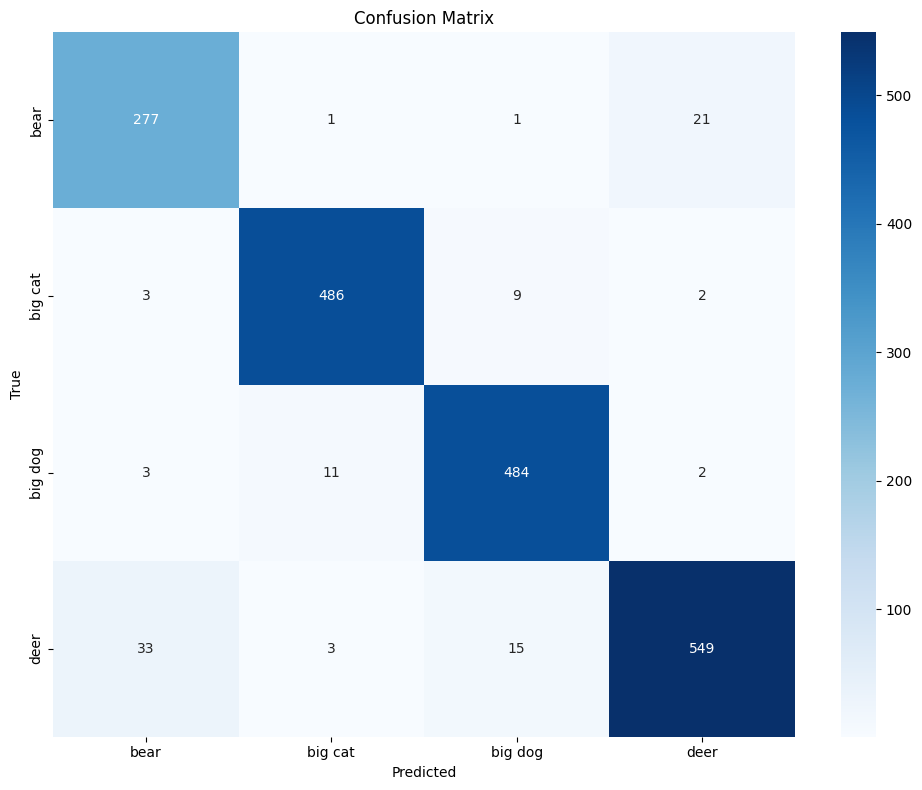


--- Evaluation Summary ---

Class: bear
  Total Images: 300
  Correct Predictions: 277
  Incorrect Predictions: 23

Class: big cat
  Total Images: 500
  Correct Predictions: 486
  Incorrect Predictions: 14

Class: big dog
  Total Images: 500
  Correct Predictions: 484
  Incorrect Predictions: 16

Class: deer
  Total Images: 600
  Correct Predictions: 549
  Incorrect Predictions: 51

--- Detailed Predictions per Image ---

Results for Ground Truth Class: bear
  Image: 8784.jpg
    Ground Truth: bear
    Fusion Model Prediction: bear (CORRECT)
  Image: 8789.jpg
    Ground Truth: bear
    Fusion Model Prediction: big dog (INCORRECT)
  Image: 8794.jpg
    Ground Truth: bear
    Fusion Model Prediction: bear (CORRECT)
  Image: 8795.jpg
    Ground Truth: bear
    Fusion Model Prediction: bear (CORRECT)
  Image: 8796.jpg
    Ground Truth: bear
    Fusion Model Prediction: bear (CORRECT)
  Image: 8797.jpg
    Ground Truth: bear
    Fusion Model Prediction: bear (CORRECT)
  Image: 8798.jpg
   

In [14]:
import os
import logging
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from ultralytics import YOLO
from sklearn.metrics import classification_report
from ultralytics.utils import LOGGER
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
LOGGER.setLevel(logging.ERROR)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"★ Using {device}")

# Initialize Models (Detection and Feature Extractors) and Freeze Weights
# Assuming 'yolo12l.pt' is available or correctly path-specified
try:
    detection_model = YOLO('yolo12l.pt').eval()
    for p in detection_model.parameters():
        p.requires_grad_(False)

    # Only EfficientNet remains
    effnet = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).eval()

    for p in effnet.parameters():
        p.requires_grad_(False)
except Exception as e:
    print(f"Error initializing models: {e}. Make sure 'yolo12l.pt' is accessible.")
    # Exit or handle error appropriately if models cannot be loaded

# Define Feature Extractor (Only EffNetFeatureExtractor remains)
class EffNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = nn.Sequential(
            model.features,
            model.avgpool
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.features(x)
        return self.flatten(x)

# Initialize feature extractor (Only EfficientNet)
try:
    effnet_feature_extractor = EffNetFeatureExtractor(effnet).to(device)
    dummy = torch.zeros(1, 3, 224, 224).to(device)
    with torch.no_grad():
        effnet_dummy_feats = effnet_feature_extractor(dummy)

    effnet_dim = effnet_dummy_feats.shape[1]
    print(f"Detected feature dims → EffNet: {effnet_dim}")
except Exception as e:
    print(f"Error initializing feature extractors: {e}")
    # Exit or handle error appropriately

# Define Classifier Model Structure (EfficientNet Only)
class EfficientNetOnlyClassifier(nn.Module):
    def __init__(self, effnet_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(effnet_dim, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, effnet_feats):
        return self.classifier(effnet_feats)


# Map Model Categories to high-level classes
# Ensure the order matches how your model was trained (alphabetical by folder name)
class_names = sorted(['bear', 'big cat', 'big dog', 'deer']) # Sort to match potential dataset loading order
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}
num_classes = len(class_names)

print(f"Class mapping used for evaluation: {class_to_idx}")


# Instantiate classifier model with the correct dims and load trained weights
fusion_model = EfficientNetOnlyClassifier(
    effnet_dim=effnet_dim,
    num_classes=num_classes
).to(device)

# **UPDATE THE MODEL PATH HERE** to the model trained with EfficientNet only features
model_path = 'best_animal_EfficientNet_only_model.pth' # Using the name saved in the training loop

try:
    fusion_model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"Successfully loaded model weights from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
    # Exit or handle error appropriately
except Exception as e:
    print(f"Error loading model weights: {e}")
    # Exit or handle error appropriately


fusion_model.eval() # Set the model to evaluation mode

# Define the test dataset directory
test_root = r"D:\SPRING 2025\Deep Learning\PROJECT\Datasets_MAIN\test_dataset"

# Define the test transform (as provided in your code)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dictionary to store results: {ground_truth_class_name: [(image_path, ground_truth_name, predicted_name, is_correct), ...]}
evaluation_results = {cls_name: [] for cls_name in class_names}

# Iterate through the test directory
print(f"\nEvaluating model on images in: {test_root}")
for class_name in tqdm(class_names, desc="Processing classes"):
    class_dir = os.path.join(test_root, class_name)
    if not os.path.isdir(class_dir):
        print(f"Warning: Directory not found for class {class_name}: {class_dir}")
        continue

    ground_truth_label_idx = class_to_idx[class_name]

    for image_filename in os.listdir(class_dir):
        if image_filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(class_dir, image_filename)

            try:
                # Load and process image
                img = cv2.imread(image_path)
                if img is None:
                    print(f"Warning: Could not read image file: {image_path}")
                    continue

                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Detection and cropping (as in your AnimalDataset __getitem__)
                try:
                    with torch.no_grad():
                        det = detection_model(img_rgb)[0]
                        boxes = det.boxes.xyxy.cpu().numpy()
                except Exception:
                    boxes = np.array([])

                if boxes.size:
                    x1, y1, x2, y2 = map(int, boxes[0])
                    x2 = max(x2, x1 + 1); y2 = max(y2, y1 + 1)
                    crop = Image.fromarray(img_rgb).crop((x1, y1, x2, y2))
                else:
                    crop = Image.fromarray(img_rgb) # fallback to full img

                # Transform and prepare tensor for model input
                img_tensor = test_transform(crop).unsqueeze(0).to(device)

                # Feature extraction and prediction (Only EfficientNet)
                with torch.no_grad():
                    effnet_feats = effnet_feature_extractor(img_tensor)
                    output = fusion_model(effnet_feats) # Pass only effnet_feats
                    predicted_label_idx = torch.argmax(output, dim=1).item()

                predicted_class_name = idx_to_class[predicted_label_idx]
                is_correct = (predicted_label_idx == ground_truth_label_idx)

                evaluation_results[class_name].append((image_path, class_name, predicted_class_name, is_correct))

            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                evaluation_results[class_name].append((image_path, class_name, "Error", False)) # Mark as incorrect due to error

# --- Display Results ---
# Prepare data for metrics calculation and confusion matrix
y_true = []
y_pred = []

for class_name in class_names:
    for _, gt_name, pred_name, _ in evaluation_results[class_name]:
        y_true.append(class_to_idx[gt_name])
        if pred_name == "Error":
            # Handle error cases by predicting a random class or the most common one
            y_pred.append(class_to_idx[class_name])  # Using true class as fallback
        else:
            y_pred.append(class_to_idx[pred_name])


# Per-class metrics
print("\n=== Per-Class Metrics ===")
for class_name in class_names:
    class_idx = class_to_idx[class_name]
    
    # Create binary classification arrays for this class
    binary_true = [1 if y == class_idx else 0 for y in y_true]
    binary_pred = [1 if y == class_idx else 0 for y in y_pred]
    
    precision = precision_score(binary_true, binary_pred, zero_division=0)
    recall = recall_score(binary_true, binary_pred, zero_division=0)
    f1 = f1_score(binary_true, binary_pred, zero_division=0)
    
    print(f"\n{class_name.capitalize()}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  F1 Score: {f1:.3f}")

# Overall metrics
print("\n=== Overall Metrics ===")
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Macro Average (treats all classes equally):")
print(f"  Precision: {precision_macro:.3f}")
print(f"  Recall: {recall_macro:.3f}")
print(f"  F1 Score: {f1_macro:.3f}")

print("\nWeighted Average (accounts for class imbalance):")
print(f"  Precision: {precision_weighted:.3f}")
print(f"  Recall: {recall_weighted:.3f}")
print(f"  F1 Score: {f1_weighted:.3f}")

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("\n--- Evaluation Summary ---")

total_correct = 0
total_incorrect = 0

for class_name in class_names:
    results_for_class = evaluation_results[class_name]
    class_correct = sum(1 for _, _, _, is_correct in results_for_class if is_correct)
    class_incorrect = len(results_for_class) - class_correct

    total_correct += class_correct
    total_incorrect += class_incorrect

    print(f"\nClass: {class_name}")
    print(f"  Total Images: {len(results_for_class)}")
    print(f"  Correct Predictions: {class_correct}")
    print(f"  Incorrect Predictions: {class_incorrect}")

print("\n--- Detailed Predictions per Image ---")

for class_name in class_names:
    print(f"\nResults for Ground Truth Class: {class_name}")
    results_for_class = evaluation_results[class_name]

    if not results_for_class:
        print("  No images found or processed for this class.")
        continue

    for image_path, gt_name, pred_name, is_correct in results_for_class:
        status = "CORRECT" if is_correct else "INCORRECT"
        print(f"  Image: {os.path.basename(image_path)}")
        print(f"    Ground Truth: {gt_name}")
        print(f"    Fusion Model Prediction: {pred_name} ({status})")

total_evaluated = total_correct + total_incorrect
overall_accuracy = (total_correct / total_evaluated * 100) if total_evaluated > 0 else 0
print("\n--- Overall Results ---")
print(f"Total Images Evaluated: {total_evaluated}")
print(f"Overall Correct Predictions: {total_correct}")
print(f"Overall Incorrect Predictions: {total_incorrect}")
print(f"Overall Accuracy: {overall_accuracy:.2f}%")